In [13]:
import os
import gc, math
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
from scipy.misc import imsave
from PIL import Image
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

In [11]:
CHECKPOINT_DIR = './checkpoints/checkpoint01/'
make_train = False
validate_train = True
cutoff = 0.7
block_size = 544
img_w = 4896 # width
img_h = 3264 # height
boundaries = [100,80,70,70,40]
colors = ['red', 'blue', 'green', 'yellow', 'pink']
check_border = 20
SEAL_CLASSES = ['NoS', 'Seal', 'Other']
ROWS = 100
COLS = 100
BATCHSIZE = 16
TRAIN_DIR = '../darknet/seals/JPEGImagesBlk'
nb_perClass = int(BATCHSIZE / len(SEAL_CLASSES))

In [3]:
# Functions
def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 100
    x[:, :, 1] -= 115
    x[:, :, 2] -= 124
    return x

def create_rect5(row):
    if is_seal:
        return plt.Rectangle((row['x0'], row['y0']), row['w'], row['h'], color='red', fill=False, lw=2)
    else:
        return plt.Rectangle((row['x0'], row['y0']), row['w'], row['h'], color='red', fill=False, lw=4)

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    return cropped

In [4]:
# Load the Xtrain files
if make_train:
    rfcnCVfold2 = pd.read_csv("../coords/comp4_30000_det_test_seals_fold2.txt",\
                        delimiter = " ", header=None, names=['img', 'proba', 'x0', 'y0', 'x1', 'y1'])
    rfcnCVfold1 = pd.read_csv("../coords/comp4_30000_det_test_seals_fold1.txt",\
                        delimiter = " ", header=None, names=['img', 'proba', 'x0', 'y0', 'x1', 'y1'])
    rfcnCVfold1['img'] = rfcnCVfold1['img'].str.replace('/home/ubuntu/noaa/darknet/seals/JPEGImagesBlk/', '')
    rfcnCV = pd.concat([rfcnCVfold2, rfcnCVfold1])
    rfcnCV = rfcnCV[rfcnCV['proba']>cutoff]
    rfcnCV = rfcnCV[(rfcnCV['x1']-rfcnCV['x0'])<150]
    rfcnCV = rfcnCV[(rfcnCV['y1']-rfcnCV['y0'])<150]
    del rfcnCVfold1, rfcnCVfold2
    gc.collect()

    # Get the ground truth labels
    coords = pd.read_csv("../feat/coords_meta.csv")
    train_meta = pd.read_csv("../feat/train_meta.csv", usecols = ['id', 'height', 'width', 'all_diff'])#,\
    train_meta.columns = ['id', 'img_height', 'img_width', 'all_diff']
    coords = pd.merge(coords, train_meta, on='id', how='inner')
    coords['block_width'] = coords['width'].apply(lambda x: x*img_w).div(coords['img_width'], axis=0).apply(int)%block_size
    coords['block_height'] = coords['height'].apply(lambda x: x*img_h).div(coords['img_height'], axis=0).apply(int)%block_size
    coords['block'] = coords['width'].apply(lambda x: x*img_w).div(coords['img_width'], axis=0).apply(int).apply(lambda x: x/block_size).apply(str)+\
                        coords['height'].apply(lambda x: x*img_h).div(coords['img_height'], axis=0).apply(int).apply(lambda x: x/block_size).apply(str)

    # For each row, check if there is a seal in the block
    def is_seal(row):
        row_id, row_block = row['img'].split('_')
        seal = ((coords['id']==int(row_id)) & \
                    (coords['block'] == row_block) & \
                    (coords['block_width']>(int(row['x0'])-check_border)) & \
                    (coords['block_width']<(int(row['x1'])+check_border)) & \
                    (coords['block_height']>(int(row['y0'])-check_border)) & \
                    (coords['block_height']<(int(row['y1'])+check_border))).any()
        return int(seal)

    from tqdm import tqdm, tqdm_pandas
    tqdm_pandas(tqdm())

    rfcnCV['seal'] = rfcnCV.progress_apply(is_seal, axis=1)
    rfcnCV = rfcnCV.reset_index(drop=True)
    rfcnCV['h_diff'] = ROWS - (rfcnCV['y1'] -rfcnCV['y0'])
    rfcnCV['w_diff'] = COLS - (rfcnCV['x1'] -rfcnCV['x0'])
    rfcnCV[rfcnCV['h_diff']<0]['h_diff'] = 0
    rfcnCV[rfcnCV['w_diff']<0]['w_diff'] = 0
    rfcnCV['x0'] = rfcnCV['x0'] - rfcnCV['w_diff']/2
    rfcnCV['x1'] = rfcnCV['x1'] + rfcnCV['w_diff']/2
    rfcnCV['y0'] = rfcnCV['y0'] - rfcnCV['h_diff']/2
    rfcnCV['y1'] = rfcnCV['y1'] + rfcnCV['h_diff']/2
    rfcnCV[['x0', 'x1']] = rfcnCV[['x0', 'x1']].add(np.where(rfcnCV['x0']<0, rfcnCV['x0'].abs(), 0), axis = 0 )
    rfcnCV[['y0', 'y1']] = rfcnCV[['y0', 'y1']].add(np.where(rfcnCV['y0']<0, rfcnCV['y0'].abs(), 0), axis = 0 )
    rfcnCV[['x0', 'x1']] = rfcnCV[['x0', 'x1']].subtract(np.where(rfcnCV['x1']>block_size, (rfcnCV['x1']-block_size).abs(), 0), axis = 0 )
    rfcnCV[['y0', 'y1']] = rfcnCV[['y0', 'y1']].subtract(np.where(rfcnCV['y1']>block_size, (rfcnCV['y1']-block_size).abs(), 0), axis = 0 )
    rfcnCV.drop(['h_diff', 'w_diff'], axis=1, inplace=True)
    rfcnCV.to_pickle('../coords/rfcnCV.pkl')
else:
    rfcnCV = pd.read_pickle('../coords/rfcnCV.pkl')

In [7]:
 rfcnCV.head()

img  proba      x0      y0      x1      y1  seal
0  228_54  0.894  364.95  295.10  464.95  395.10     0
1  228_54  0.893  228.20  376.30  328.20  476.30     0
2  228_54  0.720  407.75  409.95  507.75  509.95     0
3  854_02  0.954  129.45  104.10  229.45  204.10     0
4  854_02  0.923  336.45    5.30  436.45  105.30     0

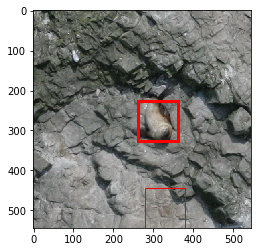

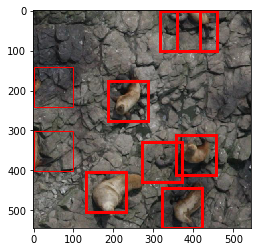

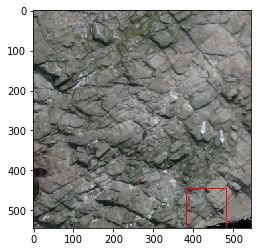

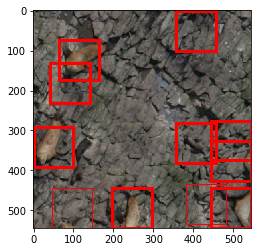

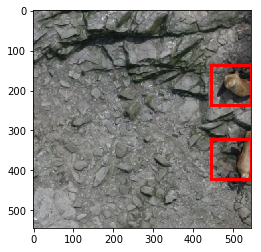

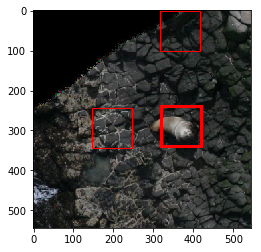

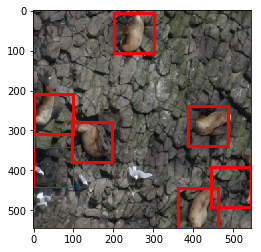

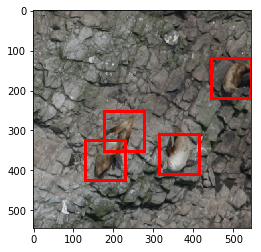

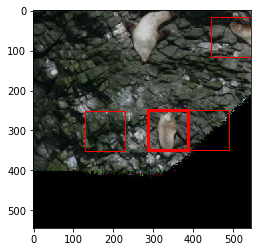

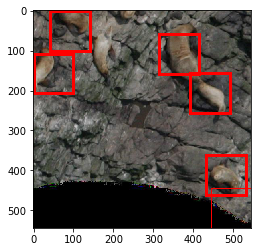

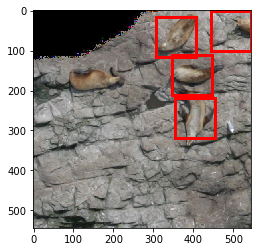

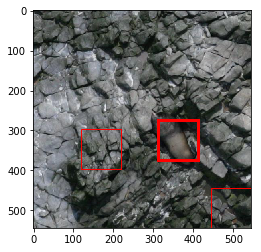

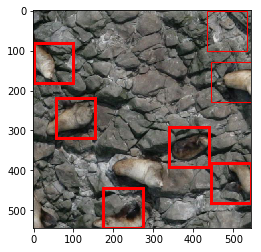

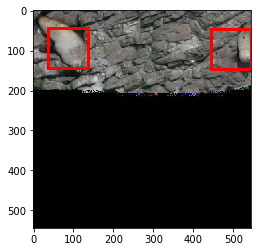

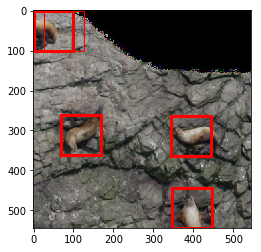

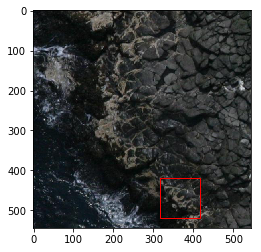

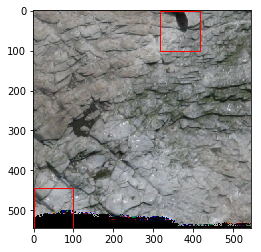

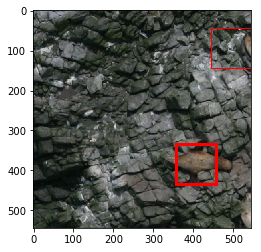

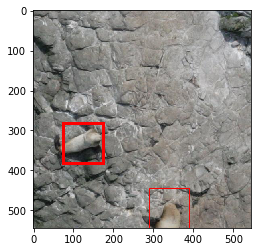

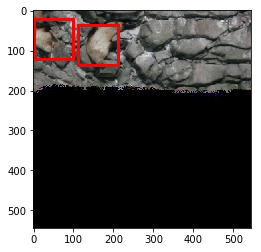

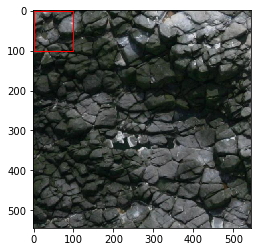

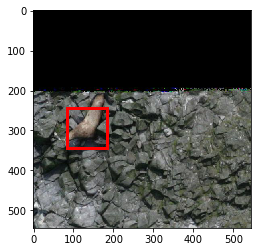

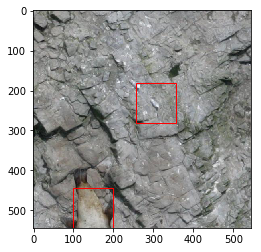

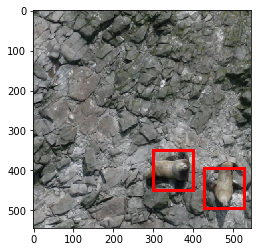

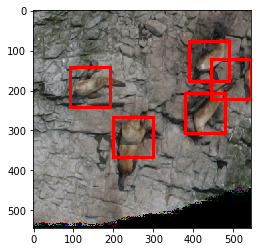

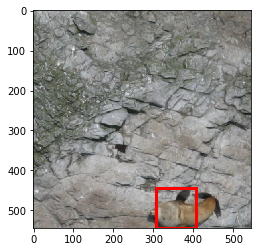

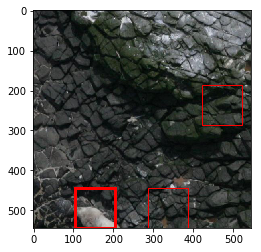

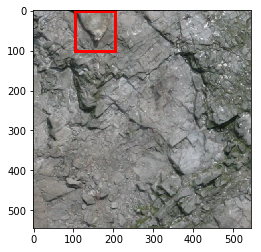

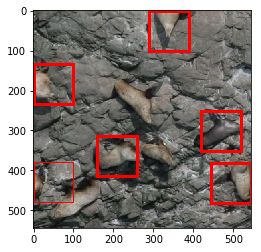

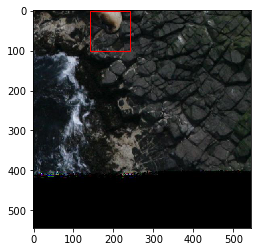

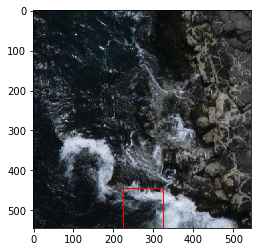

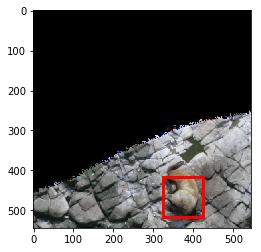

In [14]:
# Lets validate the train file
if validate_train:
    cond = rfcnCV.img.str.contains('200')
    for img_name in rfcnCV[cond].img.unique():
        img = imread('../darknet/seals/JPEGImagesBlk/%s.jpg'%(img_name))
        bbox = rfcnCV[rfcnCV['img'] == img_name]
        bbox['w'] = bbox['x1'] - bbox['x0']
        bbox['h'] = bbox['y1'] - bbox['y0']
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        for c, row in bbox.iterrows():
            plt.gca().add_patch(plt.Rectangle((row['x0'], row['y0']), row['w'],\
            row['h'], color='red', fill=False, lw=1+(2*row['seal'])))


In [ ]:
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(SEAL_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby(['seal'], as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TRAIN_DIR, row[0])
            seal = row[6]
            bbox = row[2:6]
            cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
            #plt.figure(figsize=(2,2))
            #plt.imshow(cropped) 
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            # batch_y[i,SEAL_CLASSES.index(seal)] = 1
            batch_y[i,seal] = 1
            i += 1
        # return (batch_x, batch_y)
        yield (batch_x, batch_y)

In [ ]:
#X, y = train_generator(datagen=train_datagen, df=train_df)
#type(X)

In [ ]:
# Lets make our validation set
CVsplit = rfcnCV.img.str.split('_').apply(lambda x: x[0]).astype(int) % 40 == 0
train_df = rfcnCV[~CVsplit]
valid_df = rfcnCV[CVsplit]

# validation_data (valid_x,valid_y)
df_1 = valid_df
l = valid_df.groupby('seal').size()
nb_NoF_valid = math.ceil(l.sum()/10)
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(SEAL_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    row = row.tolist()
    image_file = os.path.join(TRAIN_DIR, row[0])
    seal = row[6]
    bbox = row[2:6]
    cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    #valid_y[i,SEAL_CLASSES.index(seal)] = 1
    valid_y[i,seal] = 1
    i += 1

In [ ]:
valid_x.shape

In [ ]:
# Data generator
train_datagen = ImageDataGenerator(
    #rotation_range=180,
    #shear_range=0.2,
    #zoom_range=0.1,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
K.image_dim_ordering()

In [ ]:
#callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

In [ ]:
# Start modelling
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, init='glorot_normal')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(SEAL_CLASSES), init='glorot_normal', activation='softmax')(x)
model = Model(input=base_model.input, output=predictions)

In [ ]:
# first: train only the top layers 
for layer in base_model.layers:
    layer.trainable = False
# compile the model 
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
samples_per_epoch = 2000
# train the model on the new data for a few epochs
model.fit_generator(train_generator(datagen=train_datagen, df=train_df),
                    samples_per_epoch=samples_per_epoch,
                    nb_epoch=12, verbose=0,
                    callbacks=[early_stopping, learningrate_schedule],  # , tensorboard, model_checkpoint,
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)